Goal: get the best fit acheiveable with just a 2 + 1 dimension linear regression
General strategy: use categorical features to reduce dimensionality and create groups or nodes that share the most in common, then fit a 2d multiple linear regression on these groupings generating an N number of 3d regression fit plots 

General strategy: 

PCA to reduce dimensionality of categorical values ==> kMeans classifier to assign observations into groups ==> MLR to fit 2 numerical dimensions(probably feature engineered) 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as mn #missingno had to be installed 'pip install missingno' 
import math
import matplotlib.pyplot as plt
%matplotlib inline 


# Loading Data, Str/Int Split

In [2]:
train = pd.read_csv('train.csv')

In [3]:
intCols = train.columns[(train.dtypes == 'int64')| (train.dtypes == 'float64')]
strCols = train.columns[train.dtypes == 'object']

In [4]:
dfInt = train[intCols]
dfStr = train[strCols]
print(dfInt.shape, dfStr.shape)

(1460, 38) (1460, 43)


In [5]:
dfStr.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [6]:
# setting up the y target variable (log10(SalePrice))
target = dfInt.SalePrice.apply(math.log10)
# drop SalePrice from dfInt
dfInt = dfInt.drop(['SalePrice','Id'], axis = 1)
target.shape

(1460,)

In [7]:
target = pd.DataFrame(target)
target

SalePrice
0      5.319106
1      5.258877
2      5.349278
3      5.146128
4      5.397940
5      5.155336
6      5.487138
7      5.301030
8      5.113609
9      5.071882
10     5.112270
11     5.537819
12     5.158362
13     5.446382
14     5.195900
15     5.120574
16     5.173186
17     4.954243
18     5.201397
19     5.143015
20     5.512284
21     5.144263
22     5.361728
23     5.113609
24     5.187521
25     5.408749
26     5.129690
27     5.485721
28     5.317018
29     4.835691
...         ...
1430   5.283618
1431   5.157608
1432   4.809560
1433   5.270679
1434   5.204120
1435   5.240549
1436   5.080987
1437   5.596176
1438   5.175222
1439   5.294466
1440   5.281033
1441   5.174060
1442   5.491362
1443   5.082785
1444   5.254306
1445   5.110590
1446   5.198382
1447   5.380211
1448   5.049218
1449   4.963788
1450   5.133539
1451   5.458018
1452   5.161368
1453   4.926857
1454   5.267172
1455   5.243038
1456   5.322219
1457   5.425697
1458   5.152670
1459   5.168792

[1460 rows x 1 columns]

# Categorical transform 

In [8]:
#using Class shared on the git repo 
class NumericDataFrame():
    """
    This class converts categorical types of a dataframe into numeric types.
    It also automatically imputes missing values as the row mean.
    """
    def __init__(self, df):
        self.type_objs = df.select_dtypes(exclude=['float64',"int64"])
        self.type_numeric = df.select_dtypes(include=['float64',"int64"])
        self.transform_dict = self.get_transform_dict()
        
    def impute(self, df):
        df = df.apply(lambda x: x.fillna(1),axis=0)
        return df

    def get_transform_dict(self):
        transform_dict = {}
        for col in self.type_objs.columns:
            cats = pd.Categorical(self.type_objs[col]).categories
            d = {}
            for i, cat in enumerate(cats):
                d[cat] = i + 2
            transform_dict[col] = d
        return transform_dict

    def __call__(self):
        df = self.type_objs
        df.replace(self.transform_dict, inplace=True)
        df = pd.merge(self.type_numeric, df, left_index=True, right_index=True)
        df = self.impute(df)
        return df

In [9]:
CatNum = NumericDataFrame(dfStr)()
#normalized version
CatNumNorm=(CatNum-CatNum.min())/(CatNum.max()-CatNum.min())
CatNumNorm

MSZoning  Street  Alley  LotShape  LandContour  Utilities  LotConfig  \
0         0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
1         0.75     1.0    0.0  1.000000     1.000000        0.0       0.50   
2         0.75     1.0    0.0  0.000000     1.000000        0.0       1.00   
3         0.75     1.0    0.0  0.000000     1.000000        0.0       0.00   
4         0.75     1.0    0.0  0.000000     1.000000        0.0       0.50   
5         0.75     1.0    0.0  0.000000     1.000000        0.0       1.00   
6         0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
7         0.75     1.0    0.0  0.000000     1.000000        0.0       0.00   
8         1.00     1.0    0.0  1.000000     1.000000        0.0       1.00   
9         0.75     1.0    0.0  1.000000     1.000000        0.0       0.00   
10        0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
11        0.75     1.0    0.0  0.000000     1.000000        0.0       1.00   
12        0.75     1.0    0.0  0.333333     1.000000        0.0       1.00   
13        0.75     1.0    0.0  0.000000     1.000000        0.0       1.00   
14        0.75     1.0    0.0  0.000000     1.000000        0.0       0.00   
15        1.00     1.0    0.0  1.000000     1.000000        0.0       0.00   
16        0.75     1.0    0.0  0.000000     1.000000        0.0       0.25   
17        0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
18        0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
19        0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
20        0.75     1.0    0.0  0.000000     1.000000        0.0       0.00   
21        1.00     1.0    0.5  1.000000     0.000000        0.0       1.00   
22        0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
23        1.00     1.0    0.0  1.000000     1.000000        0.0       1.00   
24        0.75     1.0    0.0  0.000000     1.000000        0.0       1.00   
25        0.75     1.0    0.0  1.000000     1.000000        0.0       0.00   
26        0.75     1.0    0.0  1.000000     1.000000        0.0       0.00   
27        0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
28        0.75     1.0    0.0  0.000000     1.000000        0.0       0.25   
29        1.00     1.0    0.0  0.000000     1.000000        0.0       1.00   
...        ...     ...    ...       ...          ...        ...        ...   
1430      0.75     1.0    0.0  0.666667     1.000000        0.0       1.00   
1431      0.75     1.0    0.0  0.000000     1.000000        0.0       1.00   
1432      0.75     1.0    0.5  1.000000     1.000000        0.0       1.00   
1433      0.75     1.0    0.0  0.000000     1.000000        0.0       1.00   
1434      0.75     1.0    0.0  1.000000     0.666667        0.0       1.00   
1435      0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
1436      0.75     1.0    0.0  1.000000     1.000000        0.0       0.50   
1437      0.75     1.0    0.0  1.000000     1.000000        0.0       0.50   
1438      1.00     1.0    0.0  1.000000     1.000000        0.0       1.00   
1439      0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
1440      0.75     1.0    0.0  0.000000     0.000000        0.0       1.00   
1441      1.00     1.0    0.0  1.000000     1.000000        0.0       1.00   
1442      0.25     1.0    0.0  1.000000     1.000000        0.0       1.00   
1443      0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
1444      0.75     1.0    0.0  1.000000     1.000000        0.0       0.50   
1445      0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
1446      0.75     1.0    0.0  0.000000     1.000000        0.0       0.25   
1447      0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
1448      0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
1449      1.00     1.0    0.

In [10]:
# impute missingness in dfInt
from sklearn.preprocessing import Imputer

fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)
dfInt = pd.DataFrame(fill_NaN.fit_transform(dfInt))

CatNumNorm.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

# PCA experiments

In [11]:
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D



pca = decomposition.PCA(n_components=3)
pca.fit(CatNumNorm)
X = pca.transform(CatNumNorm)
CatNumNorm.columns
pca.n_components

3

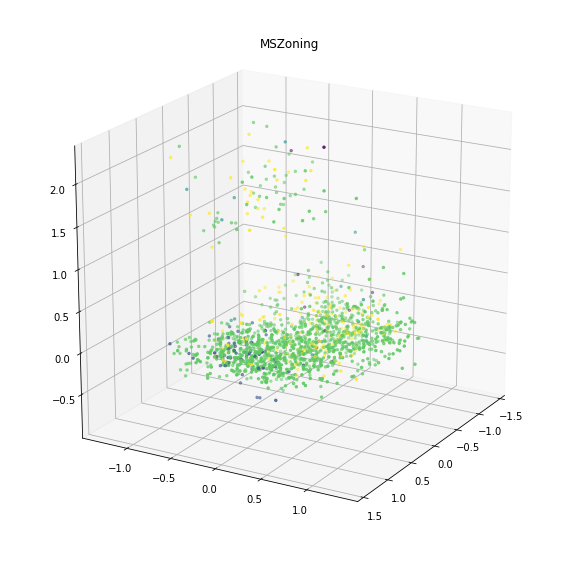

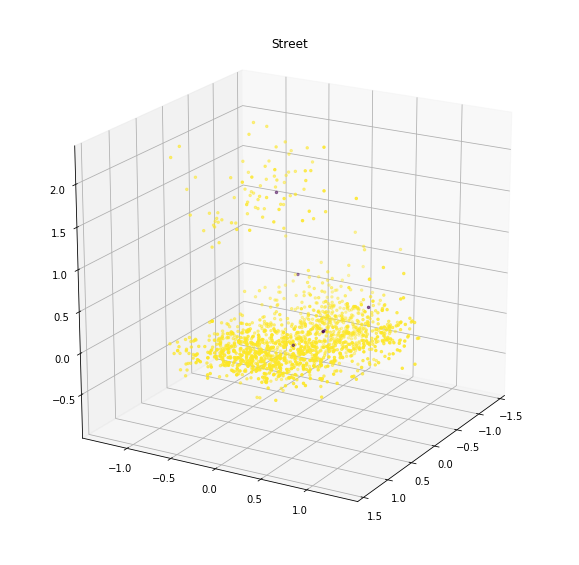

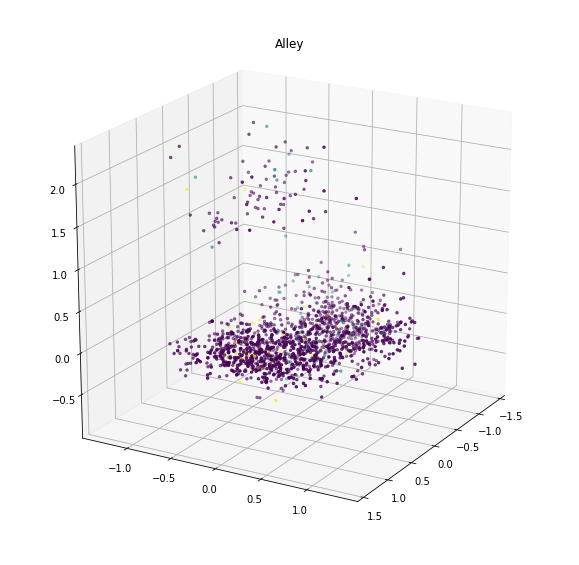

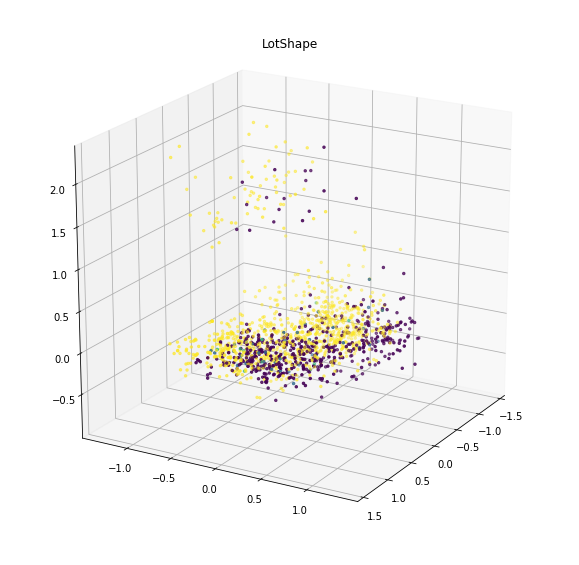

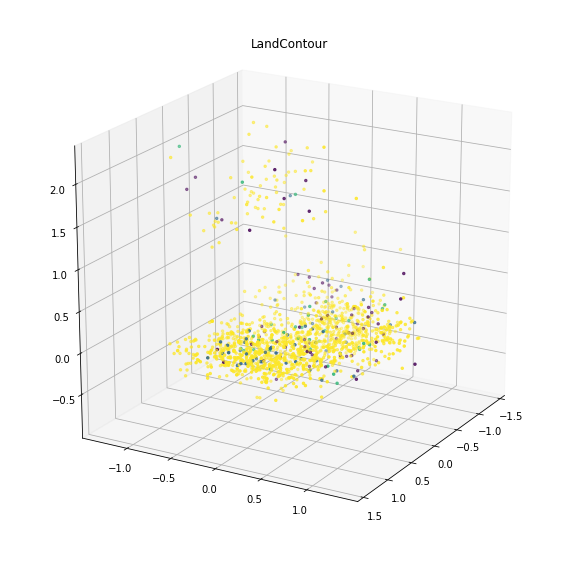

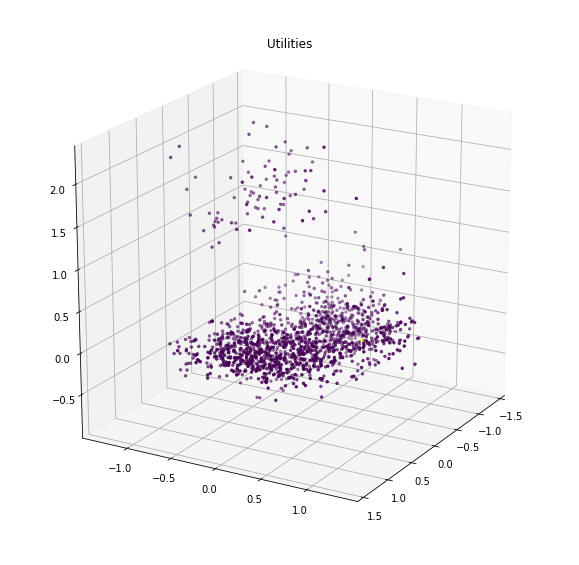

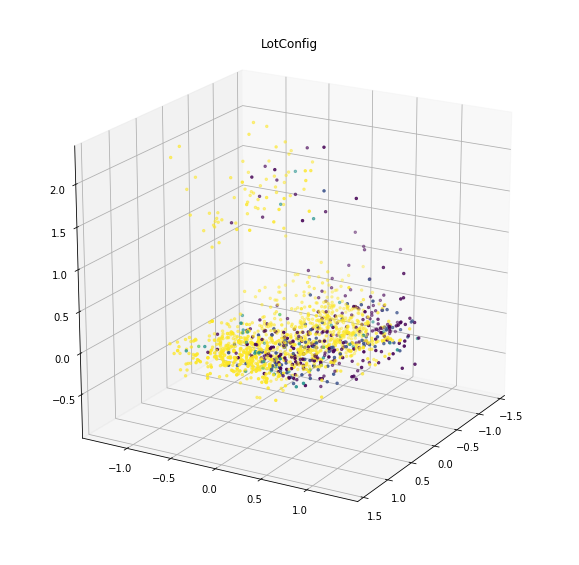

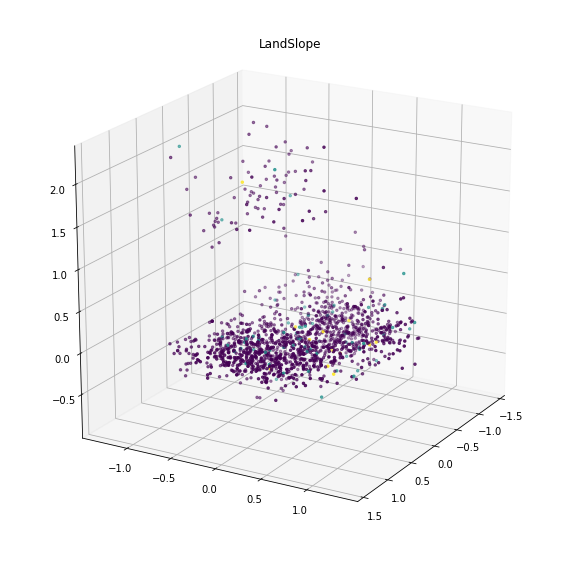

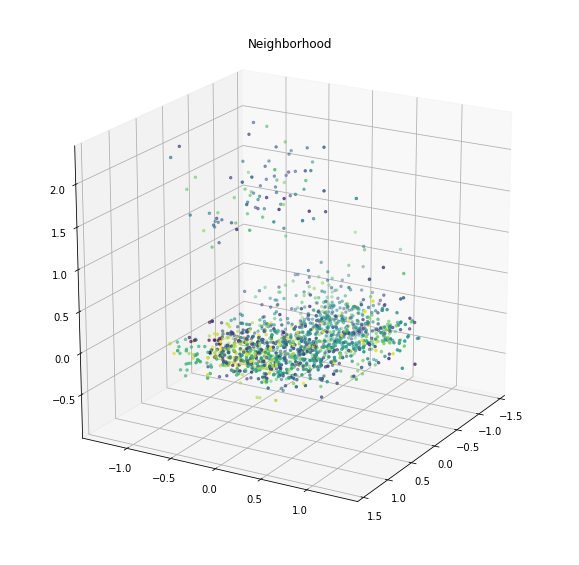

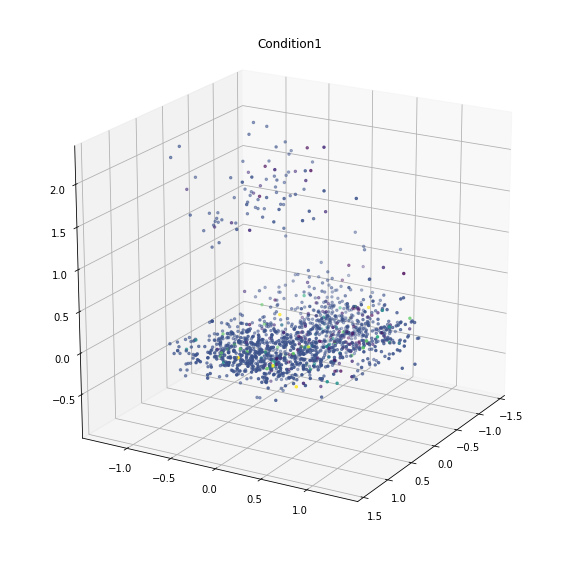

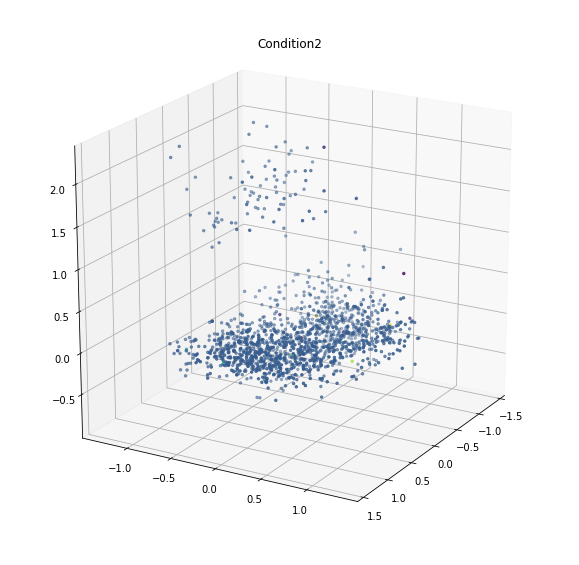

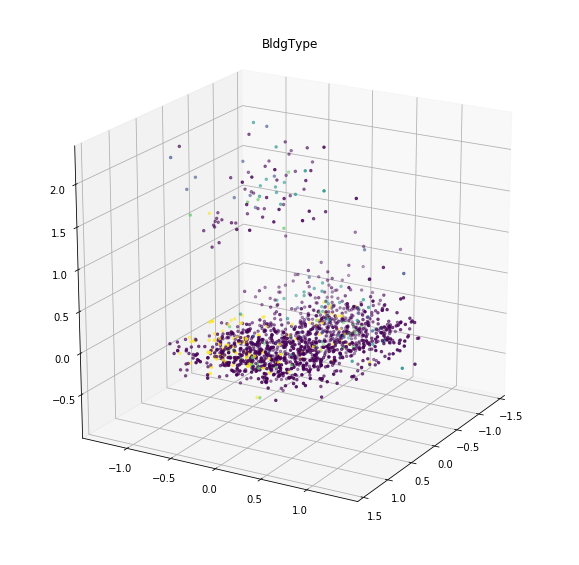

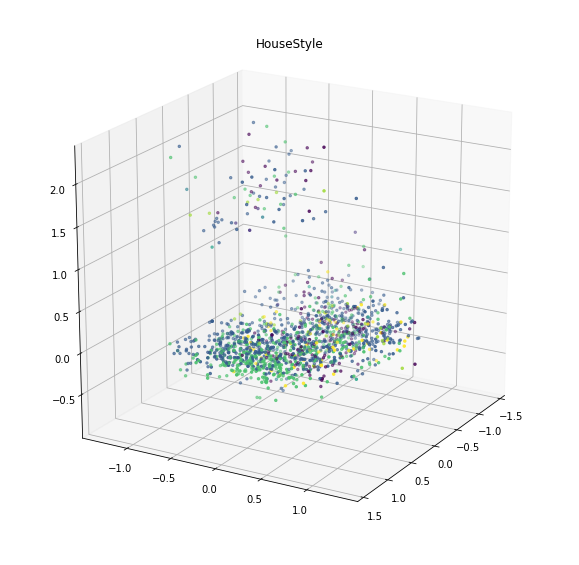

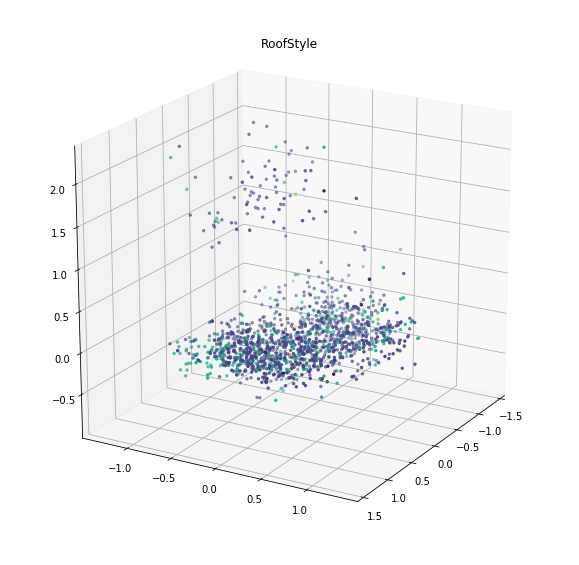

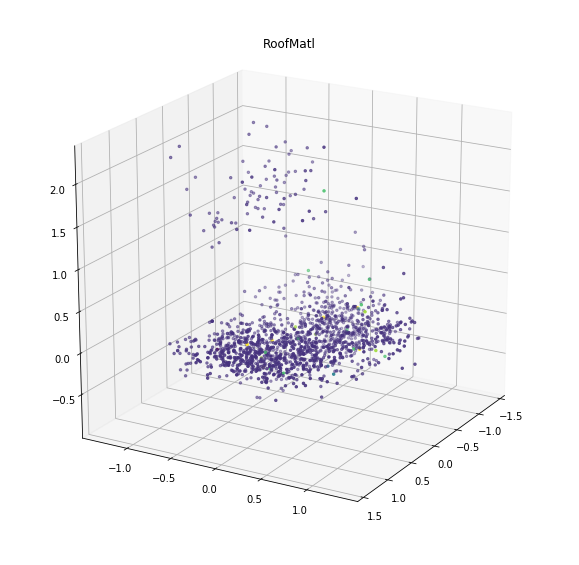

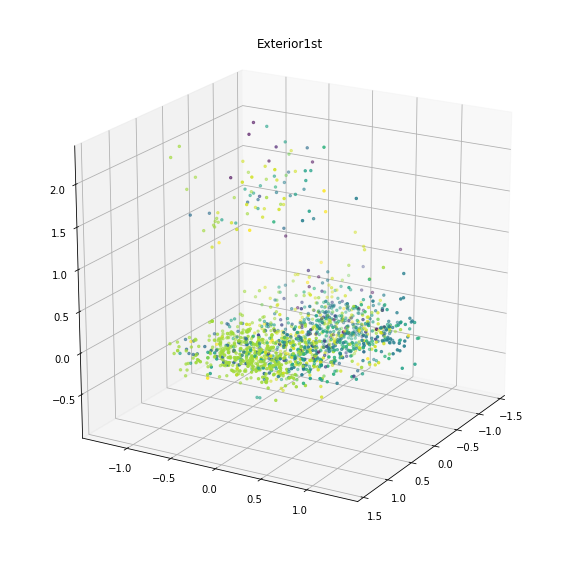

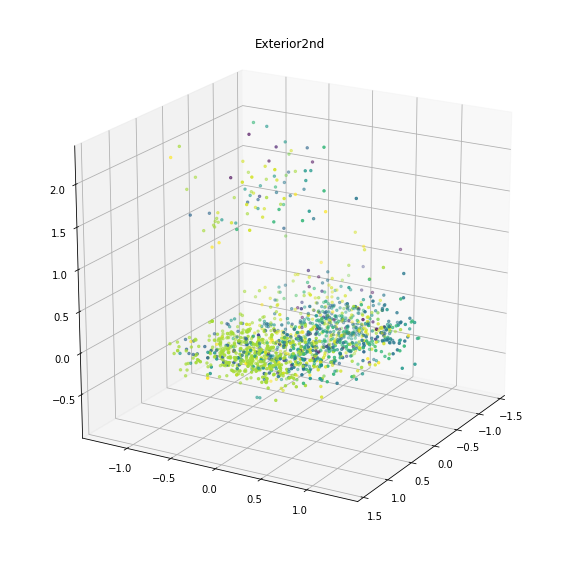

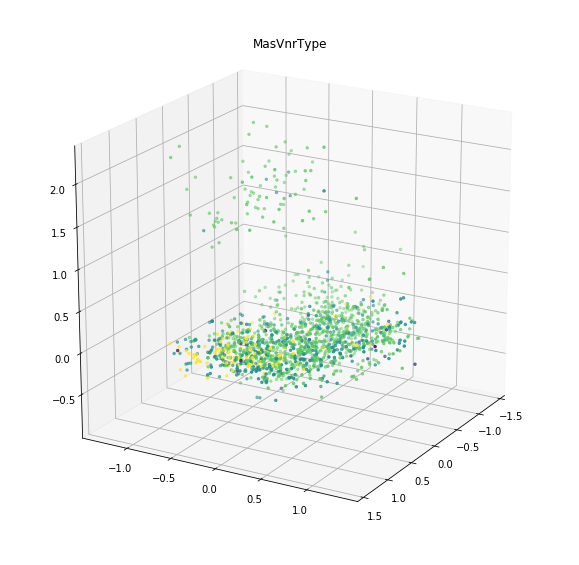

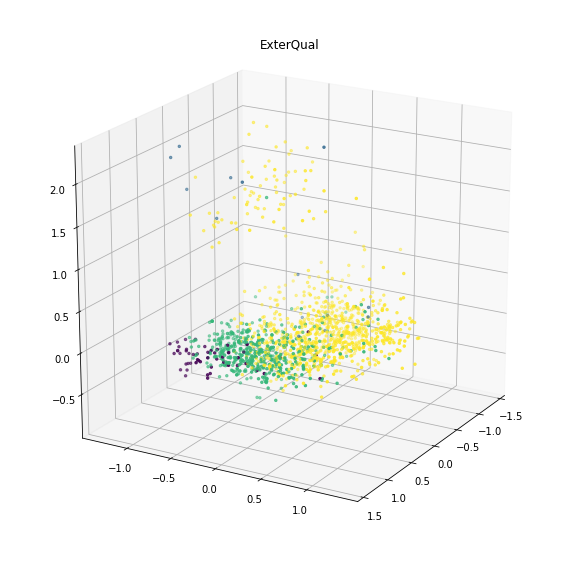

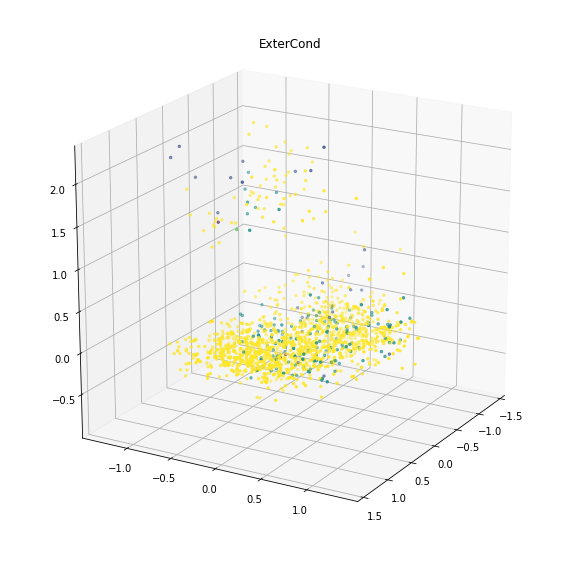

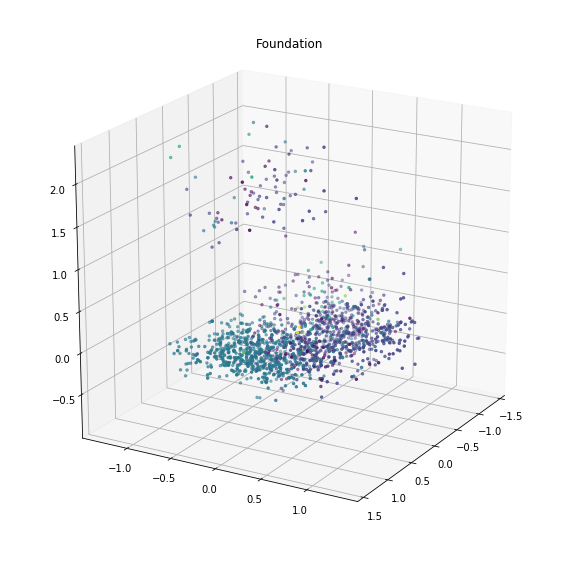

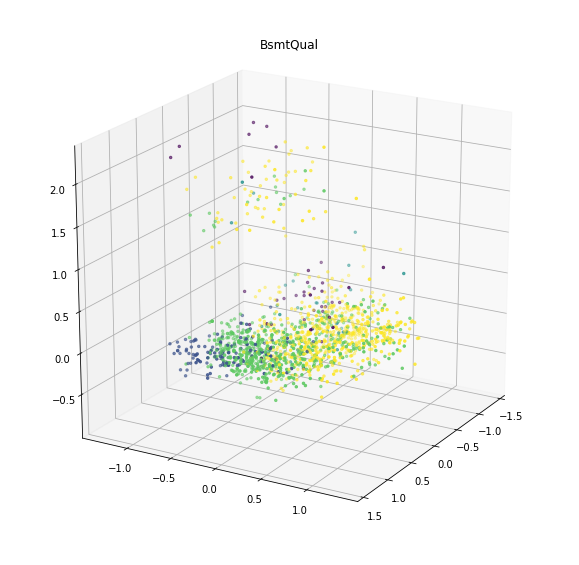

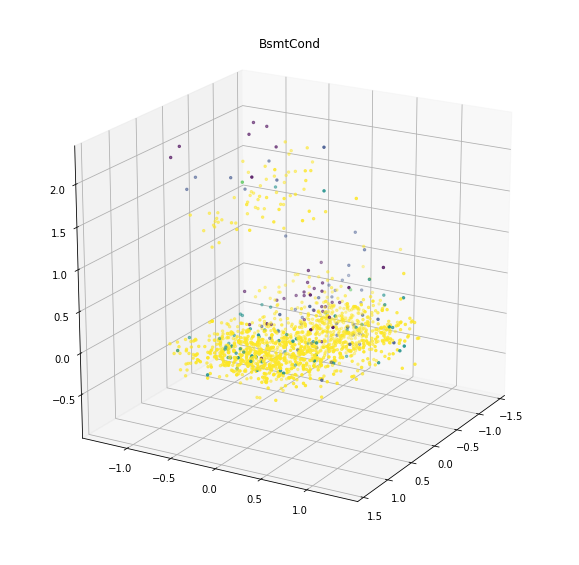

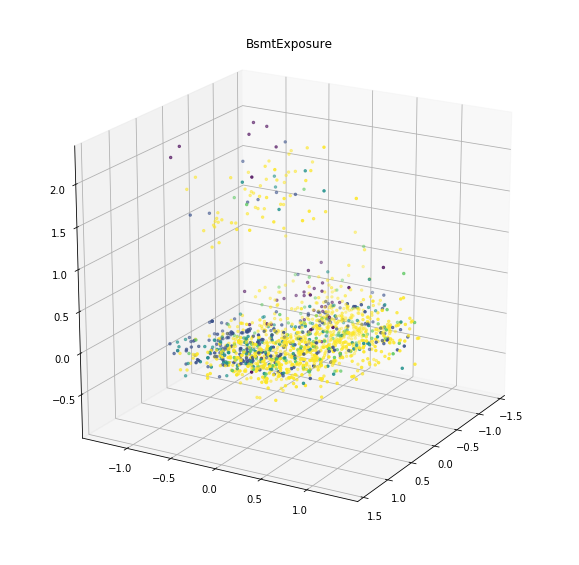

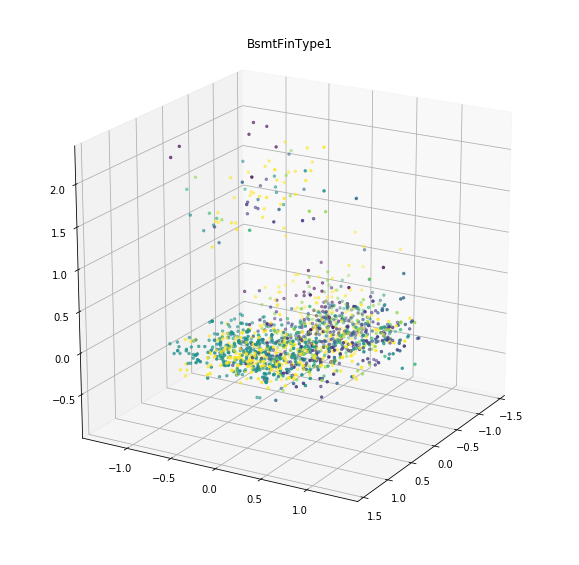

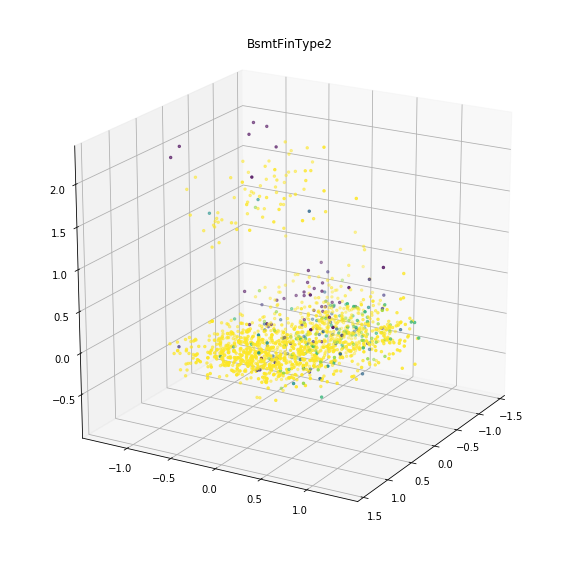

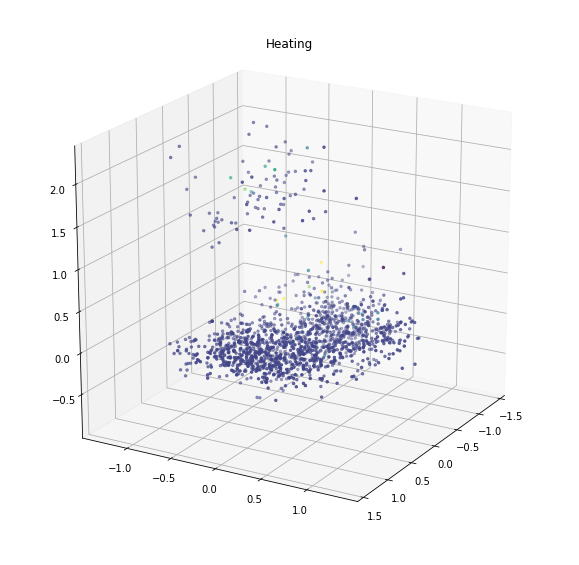

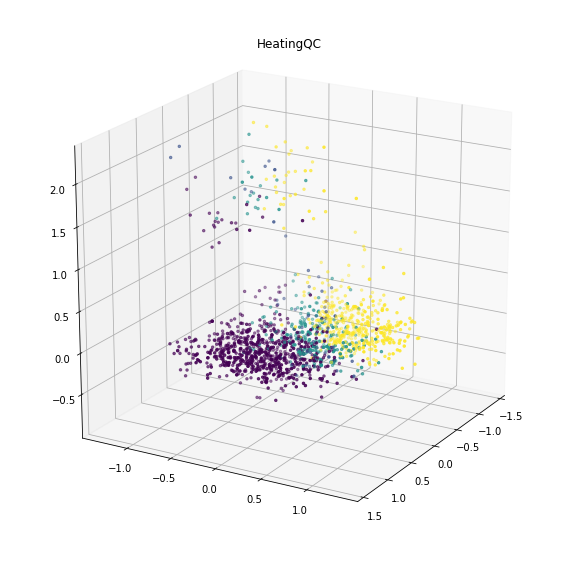

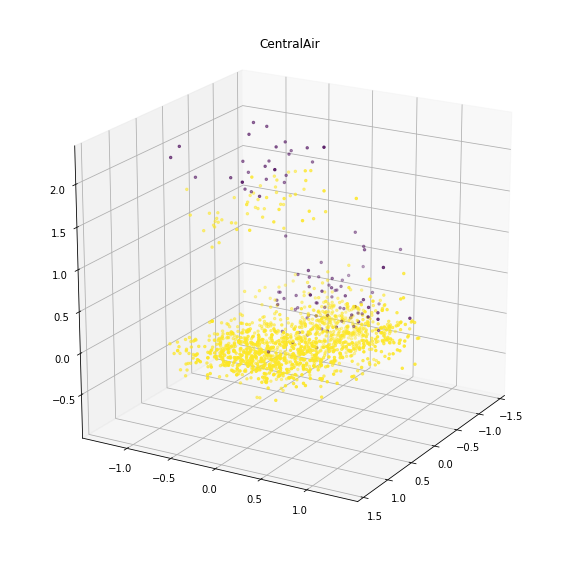

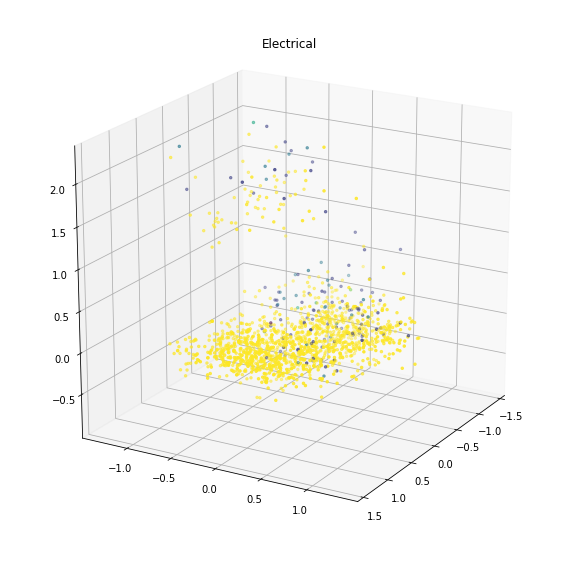

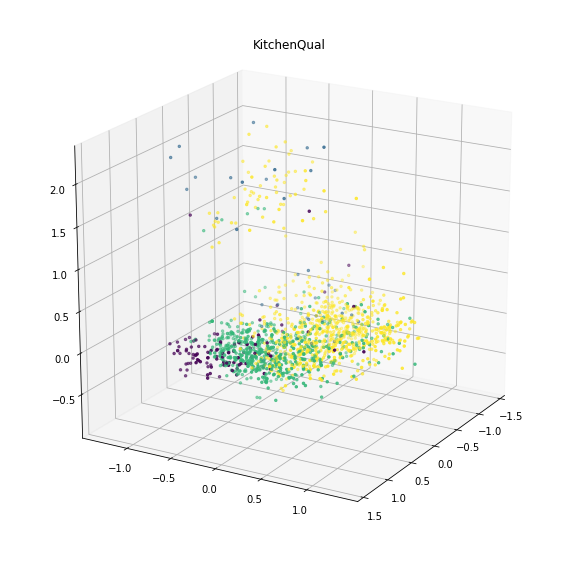

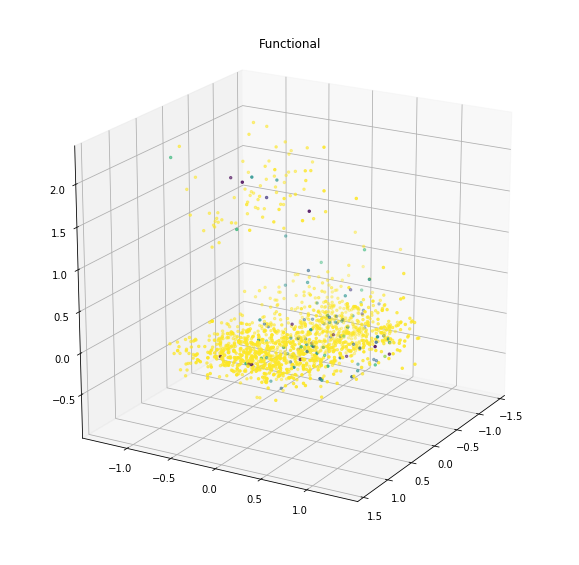

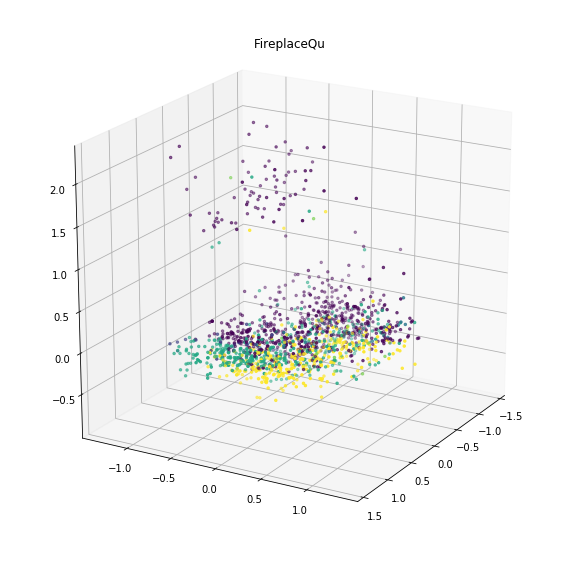

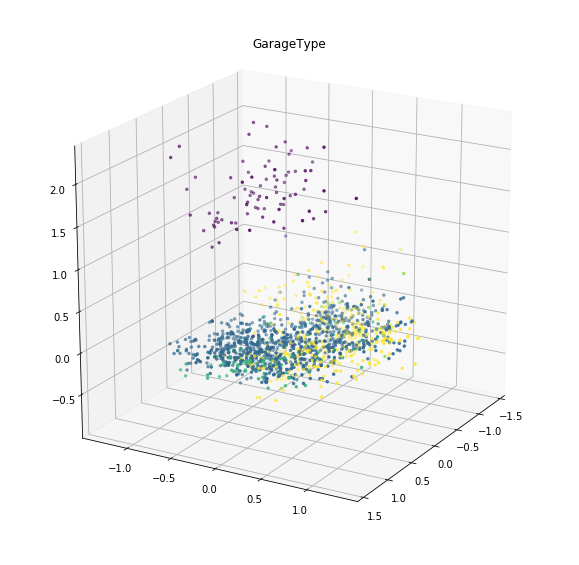

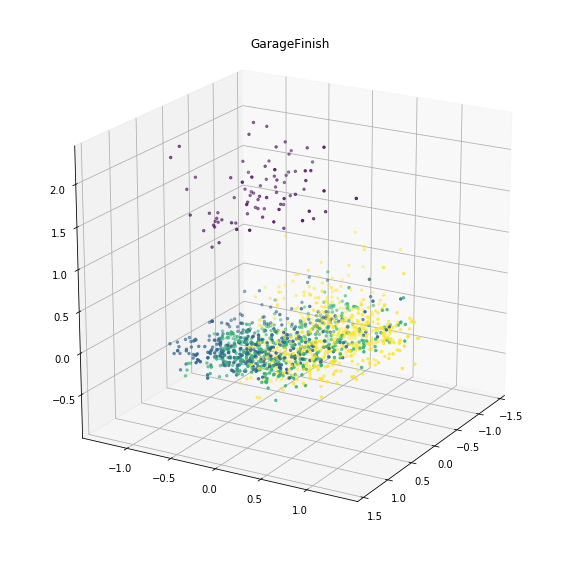

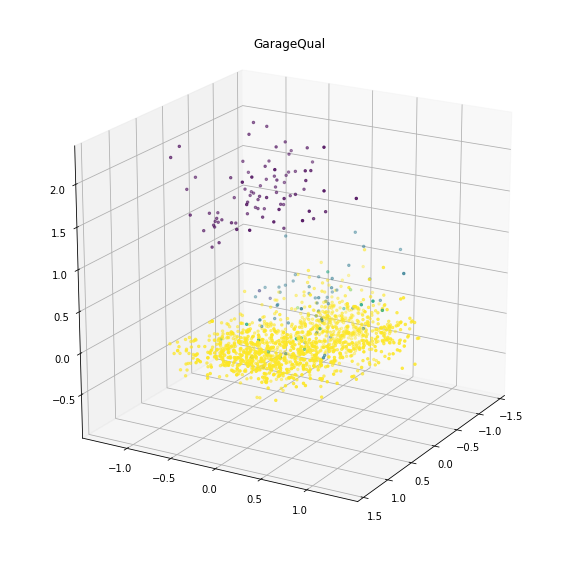

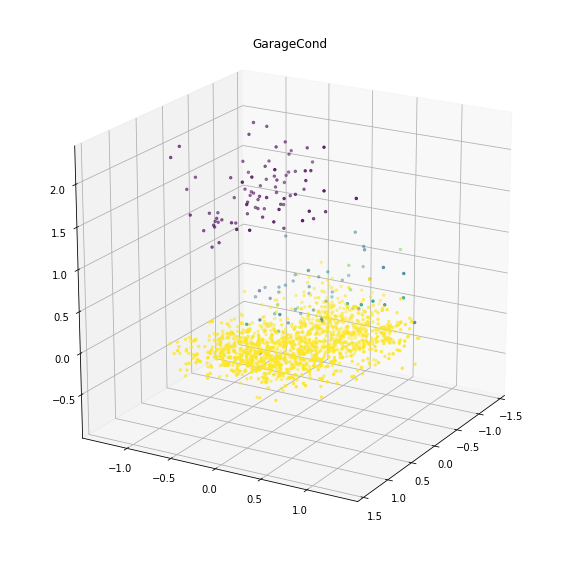

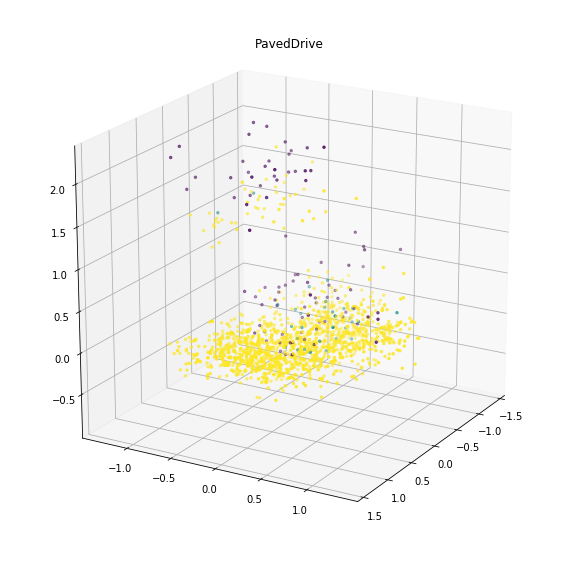

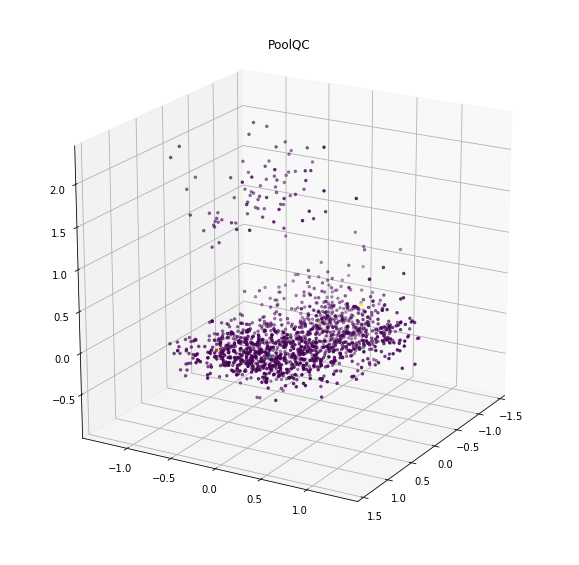

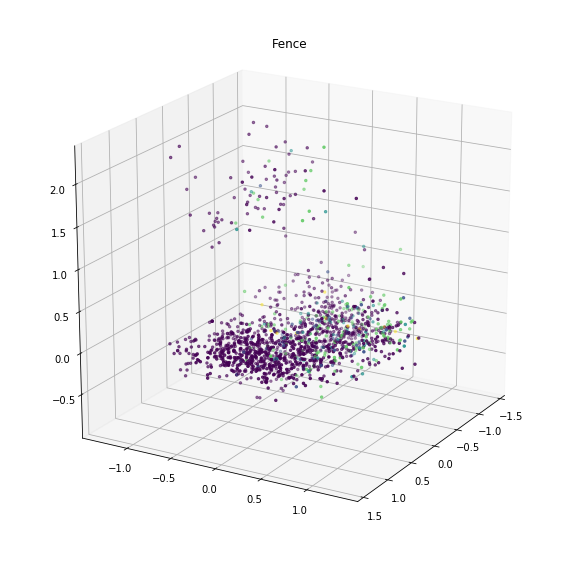

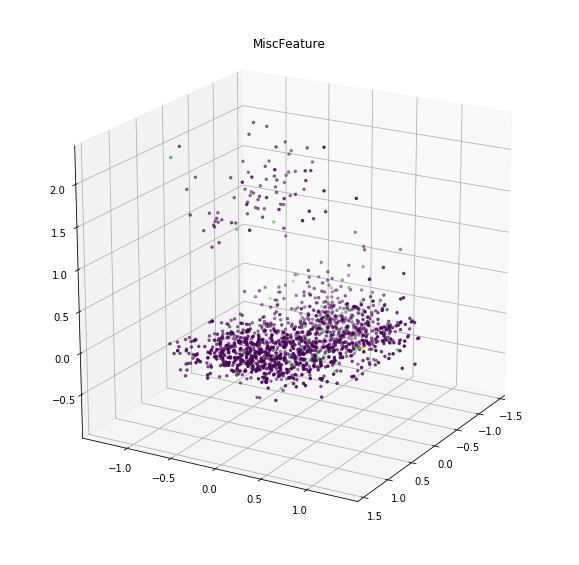

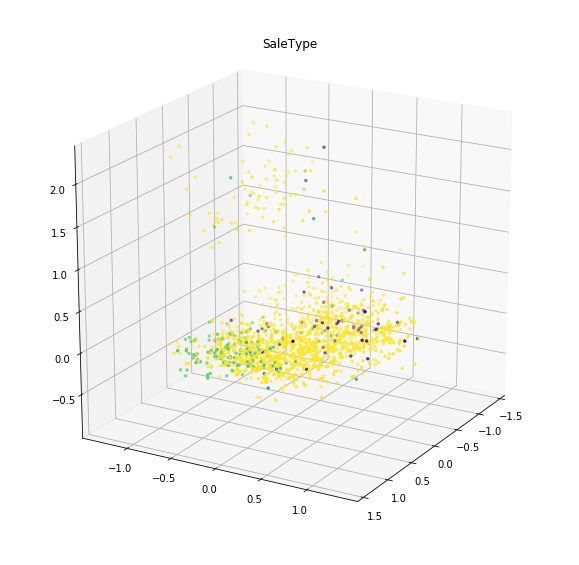

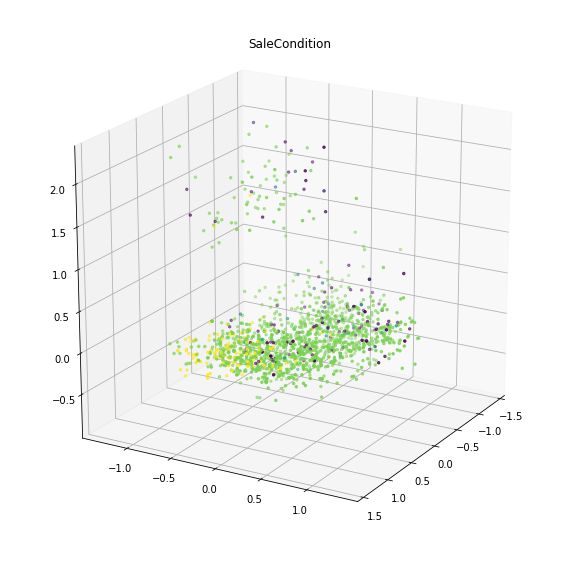

In [12]:


for each in CatNumNorm.columns:
    fig = plt.figure(figsize = [10,10])
    color = CatNumNorm[each]
    

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:,0], X[:,1], X[:,2], c=color, s=6)
    plt.viridis()
    plt.title(each)

    ax.view_init(20, 30) # change these params to rotate cube
    plt.show()


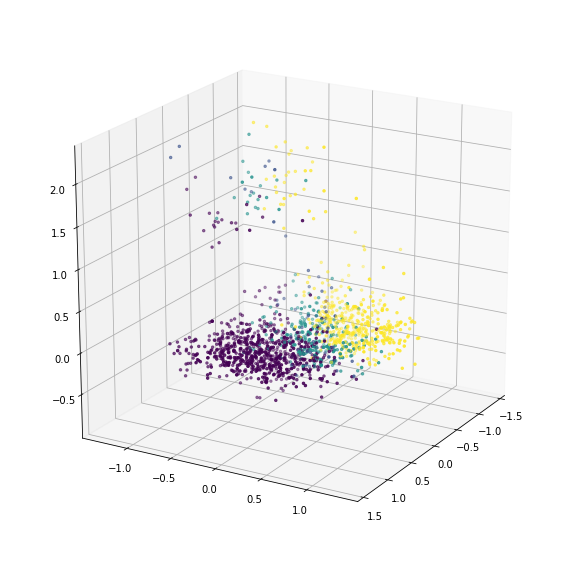

In [231]:
fig = plt.figure(figsize = [10,10])
color = CatNumNorm.HeatingQC
    

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=color, s=6)
plt.viridis()


ax.view_init(20, 30) # change these params to rotate cube
plt.show()

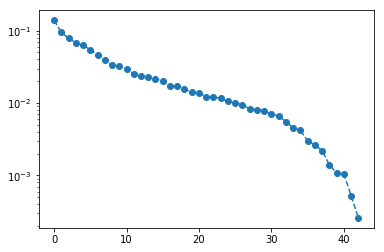

In [314]:

pca_trafo = decomposition.PCA().fit(CatNumNorm)

plt.semilogy(pca_trafo.explained_variance_ratio_, '--o')

In [86]:
pca_trafo.explained_variance_ratio_

array([ 0.13924304,  0.09481077,  0.07864358,  0.06827748,  0.0627666 ,
        0.05433367,  0.04633688,  0.03927749,  0.033437  ,  0.03202466,
        0.02928686,  0.0255943 ,  0.02342274,  0.02257379,  0.02166815,
        0.02002328,  0.01733779,  0.01710398,  0.01564015,  0.01403145,
        0.01384703,  0.01221607,  0.01207279,  0.01158276,  0.01052343,
        0.01010911,  0.00948765,  0.00828035,  0.00812986,  0.00778145,
        0.00710536,  0.00660489,  0.00554524,  0.00449308,  0.00422015,
        0.00300525,  0.00263652,  0.00219936,  0.00140544,  0.0010871 ,
        0.00105249,  0.00052166,  0.00025932])

# trying ANOVA to prune features instead (not used)

In [143]:
#from sklearn import feature_selection


#anova = feature_selection.SelectPercentile(feature_selection.f_regression)
#select = anova.fit(CatNum, target)
#SelectPercentile

In [145]:
#ANOVAscores = pd.DataFrame(list(zip(CatNum.columns, select.scores_, select.pvalues_)),\
                        #columns = ['feature', 'score', 'p_value'])
#ANOVAscores.sort_values('score', ascending = False)

In [117]:
#FeatCut = list(ANOVAscores.feature.iloc[0:3])

In [120]:
#CutCatNorm = CatNumNorm[FeatCut]

# feed into kmeans classifier

In [143]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 4)
kmeans.fit(CutCatNorm)
labels = kmeans.labels_
kmeans.score(CutCatNorm)

-20.590262962242605

In [186]:
target.shape

(1460,)

In [147]:
from sklearn.linear_model import LinearRegression

def twoLayer(n_nodes, dataCat, dataNum, tar):
    #firstlayer: k-means classifier groups into different nodes 
    #dummies = pd.get_dummies(dataCat)
    kmeans = KMeans(n_clusters = n_nodes, random_state = 10)
    kmeans.fit(dataCat)
    labels = kmeans.labels_
    #connection: modifying numeric dataframe with new groups
    
    dataNum['group'] = labels
    tar['group'] = labels
    #set up Lin regressor 
    lin = LinearRegression()
    # doing lasso and giving score for each group
    for n in range(0, n_nodes):
        X = dataNum[dataNum['group'] == n]
        y = tar[tar['group'] == n]
        X = X.iloc[:,-1]
        y = y.iloc[:,0]
        lin.fit(X,y)
        print(lin.score(X,y))

In [148]:
twoLayer(1, CutCatNorm, dfInt, target)

NameError: name 'CutCatNorm' is not defined

In [37]:
#dfInt.columns = intCols # column names lost during imputation. replacing

intColsdroped = intCols.drop(['Id', 'SalePrice'])
dfInt.columns = intColsdroped

# looking at 2 parameter MLR 

In [70]:
#first get score for every possible combination of continuous features

import itertools

columns = dfInt.columns

combos = [list(combo) for combo in combos] 





array([['MSSubClass', 'MSSubClass', 'MSSubClass', ..., 'MoSold',
        'MSSubClass', 'YrSold'],
       ['LotFrontage', 'MSSubClass', 'LotFrontage', ..., 'MoSold',
        'LotFrontage', 'YrSold'],
       ['LotArea', 'MSSubClass', 'LotArea', ..., 'MoSold', 'LotArea',
        'YrSold'],
       ..., 
       ['MiscVal', 'MSSubClass', 'MiscVal', ..., 'MoSold', 'MiscVal',
        'YrSold'],
       ['MoSold', 'MSSubClass', 'MoSold', ..., 'MoSold', 'MoSold', 'YrSold'],
       ['YrSold', 'MSSubClass', 'YrSold', ..., 'MoSold', 'YrSold', 'YrSold']],
      dtype='<U13')

In [59]:
# plug each into a linear regressor
from sklearn.linear_model import LinearRegression


In [44]:
lin = LinearRegression()


In [93]:
scores = []
for combo in combos:
    scores.append(lin.fit(dfInt[combo], target).score(dfInt[combo], target))

In [165]:
markers = [(combo[0] + ' : ' + combo[1]) for combo in combos]
#markers


In [96]:
scores = pd.DataFrame(scores)

In [149]:
scores['combo'] = markers
scores.columns = ['score', 'combo']
#scores.sort_values('score', ascending = False)

In [197]:
cutscore = scores.sort_values('score', ascending = False).iloc[list(range(0, len(scores), 2))]
cutscore[:20]

score                       combo
543  0.739973     GrLivArea : OverallQual
903  0.724129    GarageCars : OverallQual
435  0.723646      1stFlrSF : OverallQual
939  0.721457    GarageArea : OverallQual
399  0.709726   TotalBsmtSF : OverallQual
130  0.709719  OverallQual : TotRmsAbvGrd
291  0.700718    BsmtFinSF1 : OverallQual
131  0.700188    OverallQual : Fireplaces
195  0.699420       YearBuilt : GrLivArea
126  0.697891      OverallQual : FullBath
110  0.697313       OverallQual : LotArea
124  0.689207  OverallQual : BsmtFullBath
113  0.688806     OverallQual : YearBuilt
135  0.688249    OverallQual : WoodDeckSF
219  0.686969  YearRemodAdd : OverallQual
109  0.683954   OverallQual : LotFrontage
128  0.683821  OverallQual : BedroomAbvGr
132  0.683514   OverallQual : GarageYrBlt
255  0.678193    MasVnrArea : OverallQual
3    0.677926    MSSubClass : OverallQual

# feature engineering to reduce continuous variables

In [193]:
 #Quality, and area are the biggest predictors. We can aggregate sqfootage as before and give lin sqft, include garage area

#maybe we can add overallQuallity + number of + cars + fireplaces 

totalSF = dfInt['1stFlrSF'] + dfInt['2ndFlrSF'] + dfInt['TotalBsmtSF'] + dfInt['GarageArea'] + dfInt['LotArea']
totalLF = totalSF.apply(math.sqrt)
fancy = dfInt['OverallQual'] + dfInt['GarageCars'] + dfInt['Fireplaces'] + dfInt['FullBath'] + dfInt['HalfBath']
#cutscore

In [194]:
CutInt = pd.DataFrame(list(zip(totalLF, fancy)), columns = ['totalLinFt', 'fanciness'])

In [234]:
#let's check score for this engineered data set
# 4-5% improvement. this is our baseline 

print(lin.fit(CutInt, target).score(CutInt, target))
print(lin.intercept_)
intercept = lin.intercept_

0.783704393284
[ 4.58048074]


# 3d model plot 

NameError: name 'x_m' is not defined

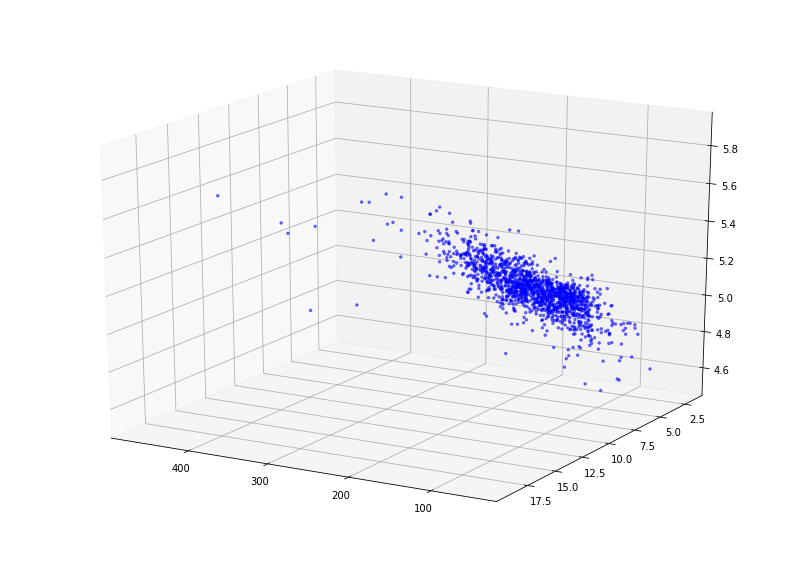

In [232]:
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection='3d')
# plot the data points
#X = np.array(list(map(lambda x: [1] + list(x), x_m)))  # Idiomatic Py3, but inefficient on Py2
#up = np.where(y_m >= np.sum(X*beta, axis=1))[0]
#down = np.where(y_m < np.sum(X*beta, axis=1))[0]
ax.scatter(totalLF, fancy, target, c= 'blue', alpha=.5, s = 6)
ax.view_init(20, 120)

# plot the plane which represents the true model
x_1 = np.linspace(min(x_m[:, 0])-.5, max(x_m[:, 0])+.5, 25)
x_2 = np.linspace(min(x_m[:, 1])-.5, max(x_m[:, 1])+.5, 25)
x_1, x_2 = np.meshgrid(x_1, x_2)
x_3 = beta[1]*x_1 + beta[2]*x_2 + beta[0]
surface_kwargs = dict(rstride=100, cstride=100, color='yellow', alpha=0.1)
ax.plot_surface(x_1, x_2, x_3, **surface_kwargs)